### **TransferLearningDR: EfficientNet-Based Diabetic Retinopathy Detector**

### **Project Overview**
- **TransferLearningDR** is a deep learning project designed to detect **Diabetic Retinopathy (DR)** from retinal fundus images, classifying each image as either **DR** or **No DR**.
    - The workflow includes **dataset preparation**, **data augmentation**, and **transfer learning** with **EfficientNetB3**, followed by deployment as an interactive **Streamlit application** and publishing on **Hugging Face**.

### **Objective**
- Build and deploy a reliable **transfer learning model** to support the early detection of **Diabetic Retinopathy**, a diabetes-related eye disease that can cause vision loss if untreated.

### **Dataset**
- **Source**: [Kaggle – Diagnosis of Diabetic Retinopathy Dataset](https://www.kaggle.com/datasets/pkdarabi/diagnosis-of-diabetic-retinopathy/data)
- **Classes**: Diabetic Retinopathy (DR), No DR
- **Preprocessing**: Images resized to **224×224(RGB)** and normalized
- Dataset re-split into **train, validation, and test sets** with balanced distributions

### Modeling Approach
- **Base Model**: **EfficientNetB3** (pre-trained on ImageNet, fine-tuned for DR classification)
- **Custom Layers**: Batch normalization, fully connected dense layer, dropout, and final sigmoid output
- **Training Setup**: Binary crossentropy loss, Adamax optimizer, early stopping, and checkpointing
- **Augmentation**: Rotation, zoom, brightness adjustment, horizontal flip

Performance
- The final model achieved high performance on the test set:
    - **Accuracy**: `98.2%`
    - **Precision**: `98.6%`
    - **Recall**: `97.9%`
    - **F1 Score**: `98.2%`

- **Diabetic Retinopathy (DR)** is a **diabetes-related eye condition** that harms **the blood vessels in the retina**—the light-sensitive layer at the back of the eye that is essential for clear vision.
- When blood sugar levels remain high for long periods, these tiny blood vessels can **swell, leak fluid, or bleed** which may cause **blurred vision, dark spots, or even vision loss**.
- **Key risk factors include**:
    - **Poorly controlled diabetes**
    - **High blood pressure or high cholesterol**
    - **Long duration of diabetes**
    - **Smoking**

Regular **eye examinations** are crucial because **early stages often have no symptoms**.

With timely medical care—such as **medication, laser treatment, or surgery**—the progression of Diabetic Retinopathy can often be slowed or prevented, helping protect long-term eyesight.

### Import Necessary Libraries

In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import hashlib
import random
from PIL import Image
import itertools
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam , Adamax  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
from huggingface_hub import login
from huggingface_hub import HfApi
from huggingface_hub import hf_hub_download
from dotenv import load_dotenv
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
base_dir = "/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy" # this is the dataset we have
splits = ["train", "valid", "test"] # this 3 folders are inside the Diagnosis of Diabetic Retinopathy

unexpected_files = []

for split in splits: 
    split_dir = os.path.join(base_dir, split) 
    for root, _, files in os.walk(split_dir): 
        for f in files: 
            if not f.lower().endswith(".jpg"):  
                unexpected_files.append(os.path.join(root, f))

if unexpected_files: 
    print("⚠️ Found unexpected files:")
    for uf in unexpected_files: 
        print(uf)
else: 
    print("✅ All files are .jpg")

✅ All files are .jpg


In [ ]:
def is_image_file(filename): 
    return filename.lower().endswith(".jpg") 

def build_dataframe(split_name):
    split_dir = os.path.join(base_dir, split_name)
    image_paths = [] 
    image_labels = [] 

    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name) 

        if not os.path.isdir(class_path): 
            continue

        for image_file in os.listdir(class_path):  
            if is_image_file(image_file): 
                full_path = os.path.join(class_path, image_file) 
                image_paths.append(full_path) 
                image_labels.append(class_name) 

    return pd.DataFrame({"image_path": image_paths, "label": image_labels})

df_train = build_dataframe("train")
df_val   = build_dataframe("valid")
df_test  = build_dataframe("test")


print(f"✅ Total valid training images: {len(df_train)}") 
print(f"✅ Total valid validation images: {len(df_val)}") 
print(f"✅ Total valid test images: {len(df_test)}") 

df_train.head()

✅ Total valid training images: 2076
✅ Total valid validation images: 531
✅ Total valid test images: 231


,image_path,label
0,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
1,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
2,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
3,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
4,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR


In [4]:
df_val.head()

,image_path,label
0,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
1,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
2,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
3,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
4,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR


In [5]:
df_test.head()

,image_path,label
0,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
1,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
2,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
3,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR
4,/kaggle/input/diagnosis-of-diabetic-retinopath...,DR


In [6]:
print(f"The ratio between the labels in the Training Images")
print(df_train["label"].value_counts())
print("="*100)
print(f"The ratio between the labels in the validation Images")
print(df_val["label"].value_counts())
print("="*100)
print(f"The ratio between the labels in the testing Images")
print(df_test["label"].value_counts())

The ratio between the labels in the Training Images
label
DR       1050
No_DR    1026
Name: count, dtype: int64
The ratio between the labels in the validation Images
label
No_DR    286
DR       245
Name: count, dtype: int64
The ratio between the labels in the testing Images
label
No_DR    118
DR       113
Name: count, dtype: int64


### Data Exploration and Visualization

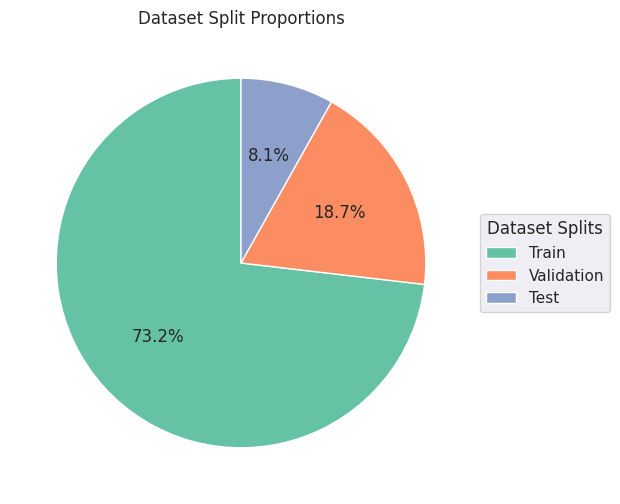

In [ ]:
split_counts = {
    "Train": len(df_train),
    "Validation": len(df_val),
    "Test": len(df_test)
}


labels = list(split_counts.keys()) 
sizes = list(split_counts.values()) 
colors = plt.cm.Set2.colors[:len(labels)]


plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors
)


plt.legend(
    wedges, labels, 
    title="Dataset Splits", 
    loc="center left", 
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title("Dataset Split Proportions")
plt.show()

In [ ]:
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True) 

print("✅ Total images:", len(df_all)) 

✅ Total images: 2838


In [9]:
df_all["label"].value_counts()

label
No_DR    1430
DR       1408
Name: count, dtype: int64

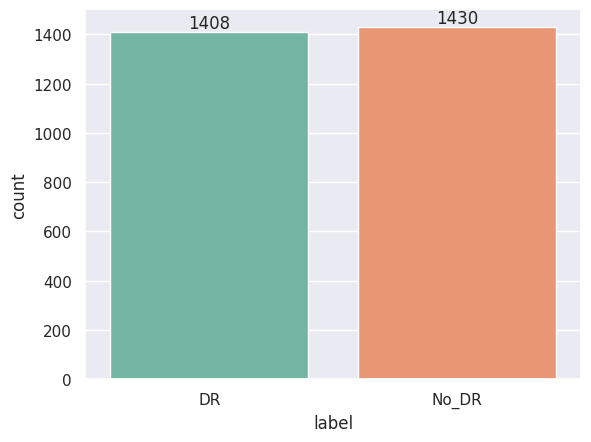

In [ ]:
ax = sns.countplot(data=df_all, x='label', palette='Set2')
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,   
        height,                           
        int(height),                      
        ha="center", va="bottom"          
    )

plt.show()

Duplicate Image Detection

In [11]:
def find_duplicates_in_df(df):
    """Find duplicate images in a DataFrame using MD5 hashes."""
    hashes = {}
    duplicates = []

    for row in df.itertuples():
        image_path = row.image_path
        label = row.label

        try:
            with open(image_path, "rb") as f:
                img_hash = hashlib.md5(f.read()).hexdigest()
                if img_hash in hashes:
                    duplicates.append((label, image_path, hashes[img_hash]))
                else:
                    hashes[img_hash] = image_path
        except Exception as e:
            print(f"⚠️ Error processing {image_path}: {e}")

    df_duplicates = pd.DataFrame(
        duplicates,
        columns=["Label", "Duplicate Path", "Original Path"]
    )

    print(f"✅ Found {len(df_duplicates)} duplicates in dataset")
    return df_duplicates


def display_duplicate_images(df_duplicates, max_samples=5):  
    """Display a few duplicate/original pairs."""
    if df_duplicates.empty:
        print("No duplicates to display.")
        return

    num_samples = min(len(df_duplicates), max_samples)
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 4 * num_samples))

    for i, row in enumerate(df_duplicates.iloc[:num_samples].itertuples()):
        try:
            original = Image.open(row._3)  
            duplicate = Image.open(row._2) 

            axes[i, 0].imshow(original, cmap="gray")
            axes[i, 0].set_title(f"Original ({row.Label})")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(duplicate, cmap="gray")
            axes[i, 1].set_title("Duplicate")
            axes[i, 1].axis("off")

        except Exception as e:
            print(f"⚠️ Error displaying images: {e}")

    plt.tight_layout()
    plt.show()

In [12]:
df_duplicates = find_duplicates_in_df(df_all)

display_duplicate_images(df_duplicates, max_samples=5)

✅ Found 0 duplicates in dataset
No duplicates to display.


### Improving Dataset Splits for Balanced Training

In [ ]:
df_train, df_test = train_test_split(
    df_all, 
    test_size=0.1, 
    stratify=df_all["label"],
    random_state=42
)



df_train, df_val = train_test_split(
    df_train, 
    test_size=0.1,
    stratify=df_train["label"],
    random_state=42
)

print("Train size:", len(df_train))
print("Val size:", len(df_val))
print("Test size:", len(df_test))

Train size: 2298
Val size: 256
Test size: 284


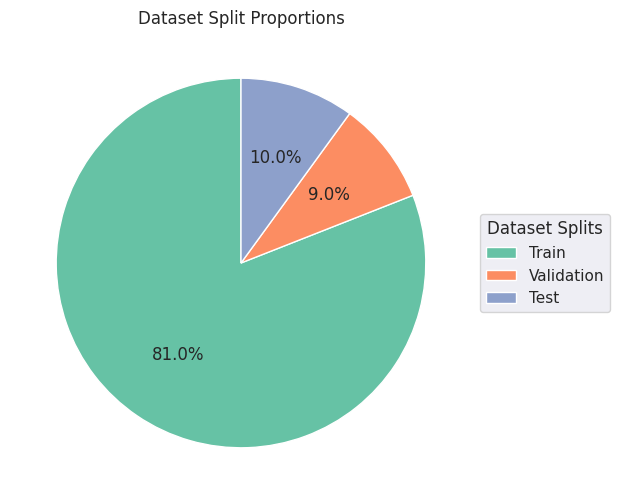

In [ ]:
split_counts = {
    "Train": len(df_train),
    "Validation": len(df_val),
    "Test": len(df_test)
}


labels = list(split_counts.keys()) 
sizes = list(split_counts.values())


colors = plt.cm.Set2.colors[:len(labels)]


plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors
)


plt.legend(
    wedges, labels, 
    title="Dataset Splits", 
    loc="center left", 
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title("Dataset Split Proportions")
plt.show()

In [15]:
df_splits = pd.DataFrame(list(split_counts.items()), columns=["Split", "Count"])
df_splits

,Split,Count
0,Train,2298
1,Validation,256
2,Test,284


In [ ]:
df_train['label'].value_counts()

label
No_DR    1158
DR       1140
Name: count, dtype: int64

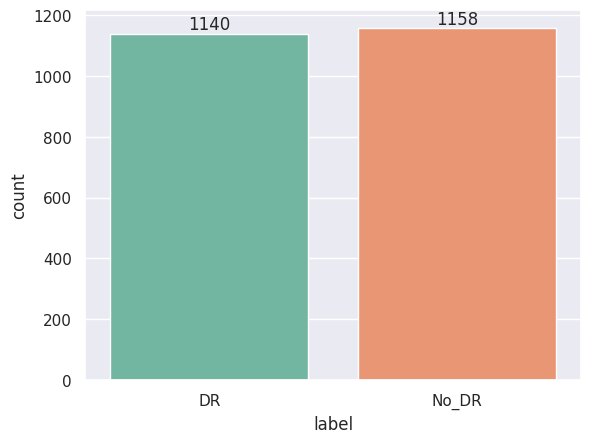

In [ ]:
ax = sns.countplot(data=df_train, x='label', palette='Set2')
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,   
        height,                           
        int(height),                      
        ha="center", va="bottom"          
    )

plt.show()

In [ ]:
df_val['label'].value_counts()

label
No_DR    129
DR       127
Name: count, dtype: int64

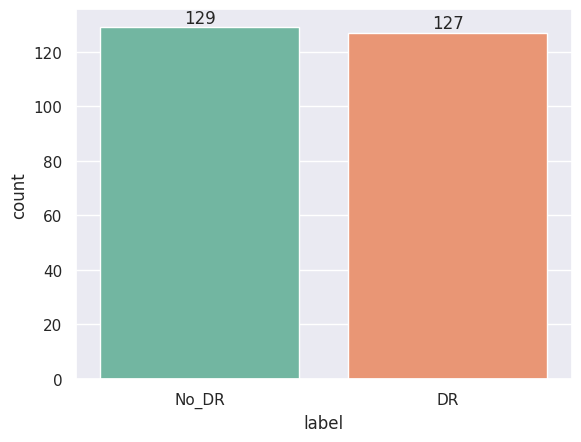

In [ ]:
ax = sns.countplot(data=df_val, x='label', palette='Set2')
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,   
        height,                           
        int(height),                      
        ha="center", va="bottom"          
    )

plt.show()

In [ ]:
df_test['label'].value_counts()

label
No_DR    143
DR       141
Name: count, dtype: int64

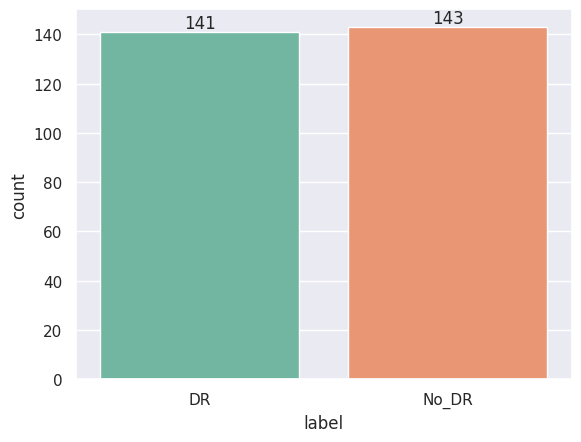

In [ ]:
ax = sns.countplot(data=df_test, x='label', palette='Set2')
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,   
        height,                           
        int(height),                      
        ha="center", va="bottom"          
    )

plt.show()

### Check for Corrupted Files

In [ ]:
def find_corrupted_images(df): 
    corrupted = [] 

    for row in df.itertuples(): 
        image_path = row.image_path 
        try:
            img = Image.open(image_path)
            img.verify()  
        except Exception as e: 
            corrupted.append((image_path, str(e)))

    df_corrupted = pd.DataFrame(corrupted, columns=["Image Path", "Error"])
    print(f"✅ Found {len(df_corrupted)} corrupted images")
    return df_corrupted


df_corrupted = find_corrupted_images(df_all) 

if not df_corrupted.empty:
    print(df_corrupted.head())
else:
    print("No corrupted images found 🚀")

✅ Found 0 corrupted images
No corrupted images found 🚀


Visualize Sample Images from Each Class

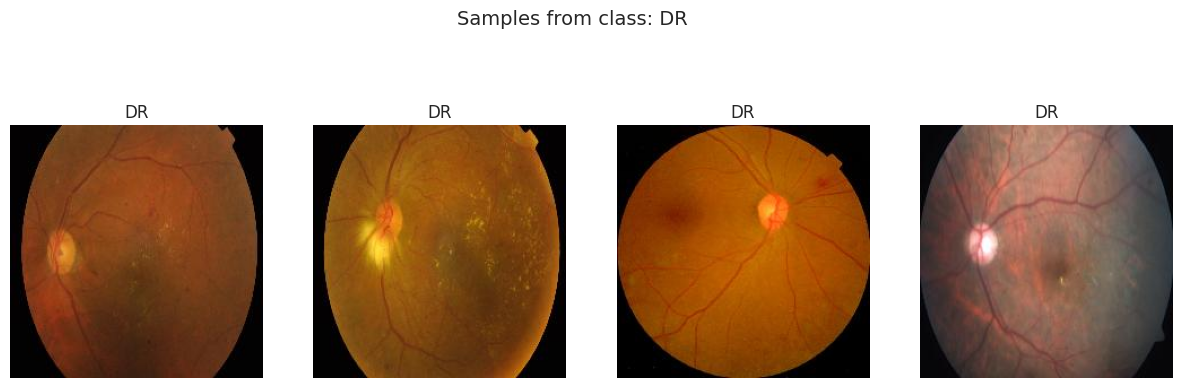

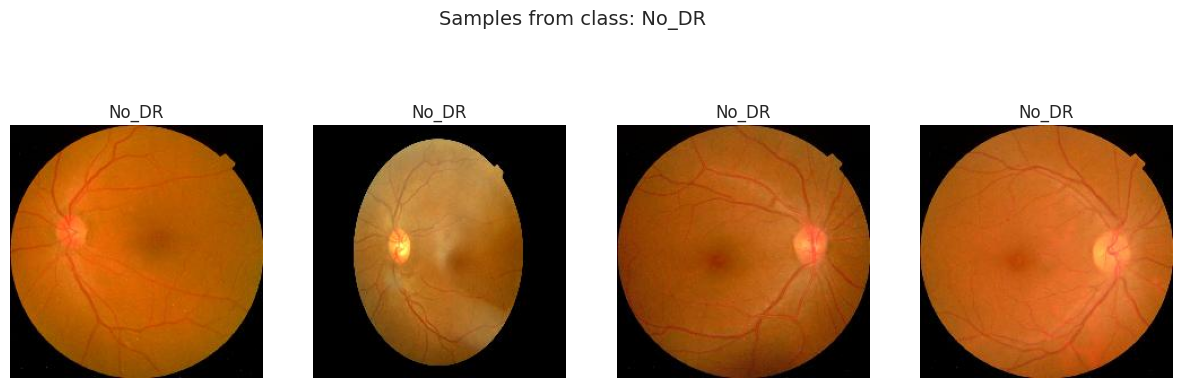

In [ ]:
def show_class_samples(df, class_name, n_samples=4): 
    """Display n_samples images from a given class."""
    sample_df = df[df["label"] == class_name].sample(n_samples, random_state=42)
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))
    fig.suptitle(f"Samples from class: {class_name}", fontsize=14)

    for i, row in enumerate(sample_df.itertuples()):
        img = Image.open(row.image_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis("off")

    plt.show()


show_class_samples(df_all, "DR", n_samples=4)
show_class_samples(df_all, "No_DR", n_samples=4)

### Image Data Augmentation and Visualization

In [ ]:
IMG_SIZE = (224, 224) 
BATCH_SIZE = 32 

train_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=1,           
    zoom_range=0.1,              
    brightness_range=[0.8, 1.2], 
    horizontal_flip=True,        
    fill_mode="nearest" 
)
val_test_image_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="rgb",  
    class_mode="binary", 
    shuffle=True,
    batch_size=BATCH_SIZE,
    seed=42
)

val_generator = val_test_image_generator.flow_from_dataframe(
    dataframe=df_val,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="binary",
    shuffle=False,
    batch_size=BATCH_SIZE
)


test_generator = val_test_image_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="binary",
    shuffle=False,
    batch_size=BATCH_SIZE
)

Found 2298 validated image filenames belonging to 2 classes.
Found 256 validated image filenames belonging to 2 classes.
Found 284 validated image filenames belonging to 2 classes.


In [25]:
print("The total number of Training Batches in the single Training epoch is", len(train_generator))
print("The total number of validation Batches", len(val_generator))
print("The total number of testing Batches", len(test_generator))

The total number of Training Batches in the single Training epoch is 72
The total number of validation Batches 8
The total number of testing Batches 9


In [ ]:
print("Train class indices:", train_generator.class_indices)
print("Val class indices:", val_generator.class_indices)
print("Test class indices:", test_generator.class_indices)

Train class indices: {'DR': 0, 'No_DR': 1}
Val class indices: {'DR': 0, 'No_DR': 1}
Test class indices: {'DR': 0, 'No_DR': 1}


### Training EfficientNetB3 for Diabetic Retinopathy Detection

### **About EfficientNetB3**
- EfficientNetB3 is part of the EfficientNet family of convolutional neural networks. It uses compound scaling to balance depth, width, and resolution for optimal performance.
- The network is pretrained on **ImageNet**, enabling **transfer learning** to medical images. Its architecture combines **convolutional layers**, **MBConv blocks**, and **squeeze-and-excitation** layers for efficient feature extraction.
- The **include_top=False** setting removes the final classification layer so we can add a **custom head** for our binary classification task.

Why Transfer Learning?
Training deep models from scratch requires very large datasets and high compute power.
Transfer learning leverages knowledge from large-scale datasets (like ImageNet) and adapts it to new tasks with limited data.
For medical imaging, this approach improves accuracy, generalization, and training efficiency.

### **Why Transfer Learning?**
- Training deep models from scratch requires very large datasets and high compute power.
- **Transfer learning** leverages **knowledge from large-scale datasets (like ImageNet)** and adapts it to new tasks with limited data.
- For medical imaging, this approach improves **accuracy**, **generalization**, and **training efficiency**.

In [ ]:
IMG_SIZE = (224, 224)
CHANNELS = 3 
IMG_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS) 
 
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
    pooling="max"
    )

model = Sequential([
    base_model, 
    BatchNormalization(), 
    Dense(256,
          kernel_regularizer=regularizers.l2(0.001),
          activity_regularizer=regularizers.l1(0.0001),
          bias_regularizer=regularizers.l1(0.00001),
          activation="relu"),
    Dropout(0.45, seed=42), 
    Dense(1, activation="sigmoid")
])


model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

I0000 00:00:1758395350.983050      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758395350.983914      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,183,408 (42.66 MB)

 Trainable params: 11,093,033 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [ ]:
early_stopping = callbacks.EarlyStopping(
    patience=10,          
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    "best_model.h5",      
    monitor="val_accuracy",
    save_best_only=True,
    mode="max", 
    verbose=1
)

In [ ]:
EPOCHS = 5 

history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=val_generator, 
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/5


I0000 00:00:1758395453.351751     107 service.cc:148] XLA service 0x794f88003120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758395453.353792     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758395453.353836     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758395461.060249     107 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1758395478.943006     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758395479.089121     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758395479.614220     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

32/72 ━━━━━━━━━━━━━━━━━━━━ 18s 450ms/step - accuracy: 0.8240 - loss: 1.2758

E0000 00:00:1758395553.447501     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758395553.591619     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758395554.114513     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758395554.264106     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758395554.413146     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8685 - loss: 1.1814
Epoch 1: val_accuracy improved from -inf to 0.85938, saving model to best_model.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.8691 - loss: 1.1799 - val_accuracy: 0.8594 - val_loss: 1.3192
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9583 - loss: 0.8140
Epoch 2: val_accuracy improved from 0.85938 to 0.97266, saving model to best_model.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 37s 505ms/step - accuracy: 0.9584 - loss: 0.8132 - val_accuracy: 0.9727 - val_loss: 0.7901
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.9718 - loss: 0.6316
Epoch 3: val_accuracy improved from 0.97266 to 0.98438, saving model to best_model.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 37s 509ms/step - accuracy: 0.9719 - loss: 0.6314 - val_accuracy: 0.9844 - val_loss: 0.6562
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9781 - loss: 0.5710
Epoch 4: val_accuracy did not improve from 0.98438
72/72 ━━━━━━━━━

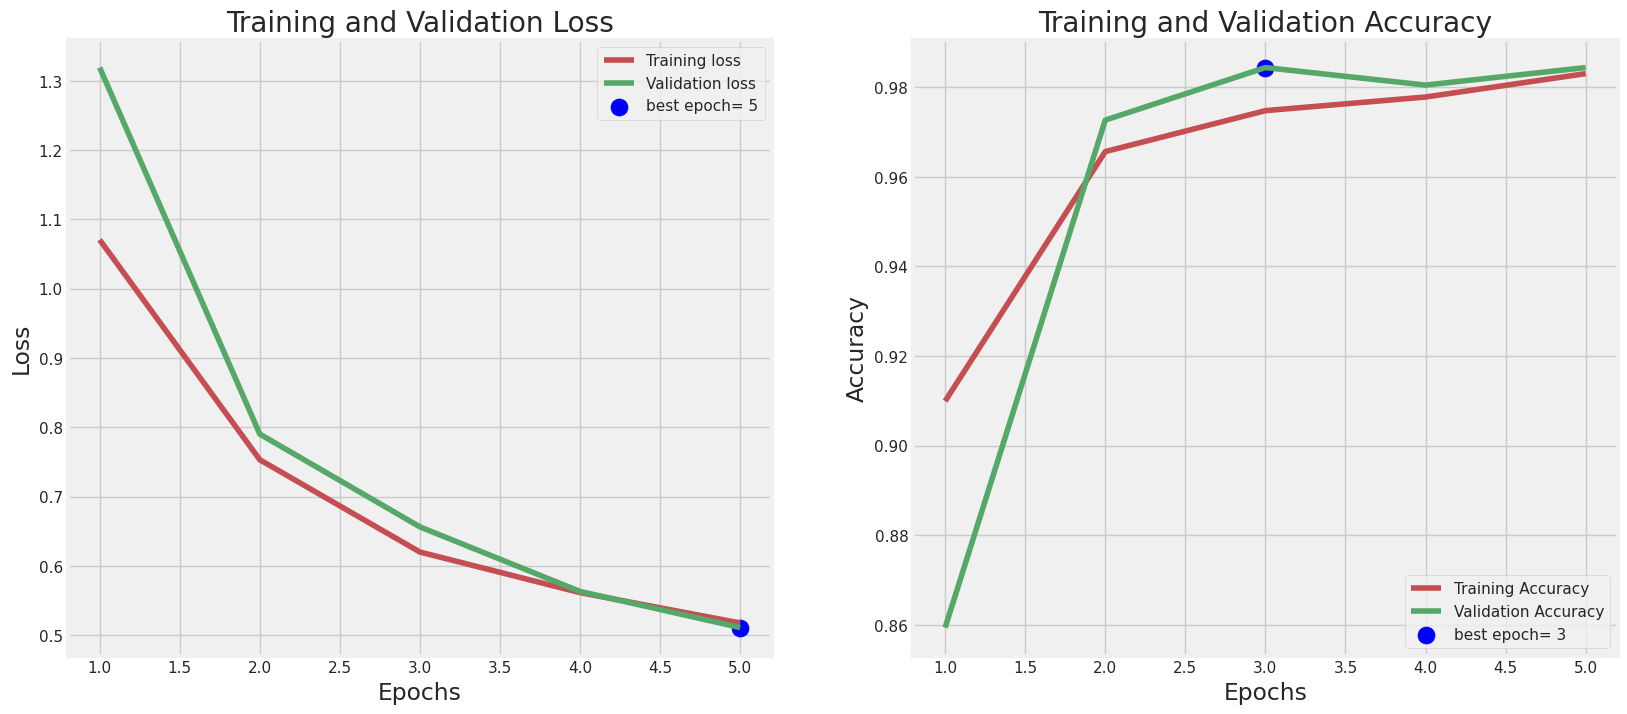

In [30]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'


plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model.evaluate(train_generator, verbose= 1) 
valid_score = model.evaluate(val_generator, verbose= 1) 
test_score = model.evaluate(test_generator, verbose= 1) 
print("\nTrain Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

72/72 ━━━━━━━━━━━━━━━━━━━━ 37s 508ms/step - accuracy: 0.9925 - loss: 0.4866
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9899 - loss: 0.5006
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9749 - loss: 0.5472

Train Loss:  0.48402535915374756
Train Accuracy:  0.9952132105827332
--------------------
Validation Loss:  0.5108133554458618
Validation Accuracy:  0.984375
--------------------
Test Loss:  0.5358796715736389
Test Accuracy:  0.9823943376541138


In [ ]:
y_pred_prob = model.predict(test_generator)
y_pred_prob

9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


array([[0.02073974],
       [0.99093705],
       [0.15774447],
       [0.02321732],
       [0.99017847],
       [0.04070558],
       [0.02683623],
       [0.02734069],
       [0.9917578 ],
       [0.03295914],
       [0.9721264 ],
       [0.91380215],
       [0.9969043 ],
       [0.99612623],
       [0.99629325],
       [0.9894894 ],
       [0.02076615],
       [0.99600583],
       [0.28814626],
       [0.98483145],
       [0.9913555 ],
       [0.9993531 ],
       [0.02514141],
       [0.00815318],
       [0.9927659 ],
       [0.9863901 ],
       [0.01266417],
       [0.02065881],
       [0.01695578],
       [0.01888939],
       [0.01638448],
       [0.01261725],
       [0.05564591],
       [0.9941093 ],
       [0.01480429],
       [0.98750025],
       [0.99888927],
       [0.9961824 ],
       [0.0229439 ],
       [0.9951179 ],
       [0.03788796],
       [0.9938361 ],
       [0.9911152 ],
       [0.03034065],
       [0.9928871 ],
       [0.01106544],
       [0.00621472],
       [0.994

In [ ]:
y_pred = (y_pred_prob >= 0.5).astype(int).ravel()
y_pred

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

In [ ]:
y_true = test_generator.classes
y_true

[0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,


In [35]:
CM = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", CM)

Confusion Matrix:
 [[139   2]
 [  3 140]]


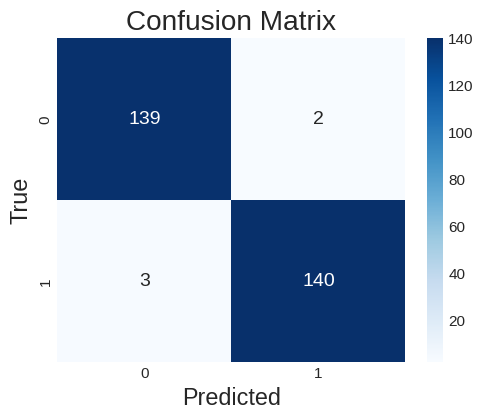

In [36]:
plt.style.use("seaborn-white")
plt.figure(figsize=(5,4))
sns.heatmap(CM, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix")
plt.show()

In [37]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))


Classification Report:
              precision    recall  f1-score   support

          DR       0.98      0.99      0.98       141
       No_DR       0.99      0.98      0.98       143

    accuracy                           0.98       284
   macro avg       0.98      0.98      0.98       284
weighted avg       0.98      0.98      0.98       284



In [38]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.9824
Precision: 0.9859
Recall:    0.9790
F1 Score:  0.9825


In [ ]:
images, labels = next(test_generator) 

image = images[0] 
true_label = labels[0] 

pred = model.predict(np.expand_dims(image, axis=0)) 
prob = pred[0][0] 
predicted_class = 1 if prob >= 0.5 else 0 

print("Probability:", prob)
print("Predicted Class:", predicted_class)
print("True Label:", true_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Probability: 0.02073974
Predicted Class: 0
True Label: 0.0


### Authenticate with Hugging Face Hub

In [50]:
load_dotenv()
token = os.getenv("HUGGINGFACE_TOKEN")
login(token=token)

In [ ]:
api = HfApi()

repo_id = "Eyaddddddd/TransferlearningDR"

api.create_repo(repo_id=repo_id, repo_type="model", private=True, exist_ok=True)

print(f"Repo created: https://huggingface.co/{repo_id}")

local_model_path = "/kaggle/working/best_model.h5"

api.upload_file(
    path_or_fileobj=local_model_path,
    path_in_repo="TransferLearningDR.h5",   
    repo_id=repo_id, 
    repo_type="model" 
)

print(f"Model uploaded to: https://huggingface.co/{repo_id}/blob/main/TransferLearningDR.h5")

Repo created: https://huggingface.co/Eyaddddddd/TransferlearningDR


Uploading...:   0%|          | 0.00/135M [00:00<?, ?B/s]

Model uploaded to: https://huggingface.co/Eyaddddddd/TransferlearningDR/blob/main/TransferLearningDR.h5


Load and Test Model from Hugging Face Hub

In [ ]:
model_path = hf_hub_download(
    repo_id="Eyaddddddd/TransferlearningDR", 
    filename="TransferLearningDR.h5"  
)

model = load_model(model_path)
print("✅ Model loaded from Hugging Face:", model_path)

TransferLearningDR.h5:   0%|          | 0.00/135M [00:00<?, ?B/s]

✅ Model loaded from Hugging Face: /root/.cache/huggingface/hub/models--Eyaddddddd--TransferlearningDR/snapshots/0a95d88cddb0263f134fbe4e8842d1ae3311afc8/TransferLearningDR.h5


In [56]:
def preprocess_image(image_path):
    IMG_SIZE = (224, 224)
    image = Image.open(image_path).convert("RGB")
    image = image.resize(IMG_SIZE)
    img_array = np.array(image)
    img_array = preprocess_input(img_array)       
    img_array = np.expand_dims(img_array, axis=0) 
    return img_array


def predict_and_show(image_path):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)[0][0]
    

    if prediction < 0.5:
        label = "⚠️ Diabetic Retinopathy likely detected"
    else:
        label = "✅ Likely No Diabetic Retinopathy" 

    
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.show()
    
    print(f"Probability: {prediction:.4f} | {label}")

In [ ]:
print(os.getcwd())

/kaggle/working


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


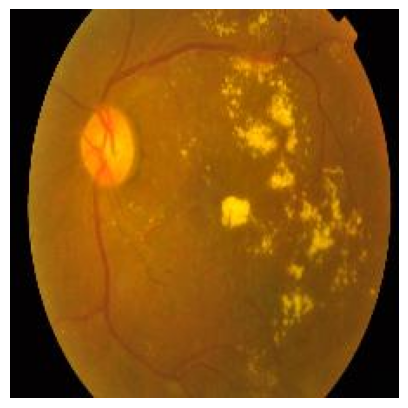

Probability: 0.0385 | ⚠️ Diabetic Retinopathy likely detected


In [68]:
predict_and_show("DR.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


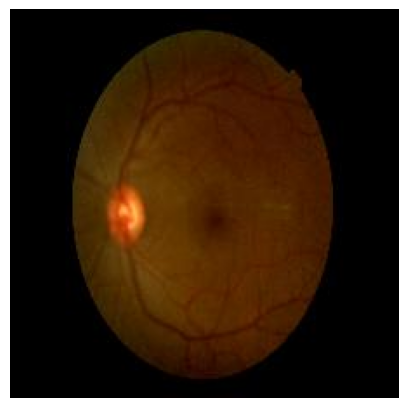

Probability: 0.9574 | ✅ Likely No Diabetic Retinopathy


In [66]:
predict_and_show("NoDR.jpg")

### Final Thoughts
- This project demonstrates the effectiveness of **transfer learning** in detecting Diabetic Retinopathy (DR) from retinal fundus images.
- By combining **EfficientNetB3’s powerful feature extraction** with a carefully prepared dataset—including **balanced re-splitting, exploratory analysis, and data augmentation**—the model achieved **exceptional accuracy, precision, and recall**, ensuring reliable classification between **DR** and **No DR**.
- Key regularization strategies such as **early stopping** and **model checkpointing** helped prevent overfitting while preserving the model’s ability to generalize across new images.
The EfficientNet architecture, pre-trained on ImageNet, provided a strong foundation for transfer learning, allowing the model to capture fine-grained retinal features critical for early DR detection.
- Deployment to both a Streamlit web application and Hugging Face Spaces transforms this work into an accessible, real-time screening tool.
- Such AI-driven solutions can support clinicians and healthcare workers, offering rapid, accurate assessments that complement professional medical evaluation.
---
Thank you for exploring the TransferLearningDR project.